In [1]:
# PART 1: DOWNLOADS

print("Downloading necessary libraries...")
!pip install git+https://github.com/openai/CLIP.git -q
!pip install torch torchvision numpy scikit-learn matplotlib -q

print("Download finished.")

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 2.1 MB/s eta 0:00:00
Download finished.


In [2]:
# PART 2: MODEL ARCHITECTURE

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import clip
from PIL import Image, ImageEnhance
import numpy as np
import random
import matplotlib.pyplot as plt
import copy

# Setting up the device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Downloading CLIP Model
clip_model, preprocess = clip.load("ViT-B/32", device=device)
clip_model.eval()
for param in clip_model.parameters():
    param.requires_grad = False

class SceneChangeClassifier(nn.Module):
    def __init__(self, input_dim=1024, hidden_dim=256):
        super(SceneChangeClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()

        # Dropout : 0.5 (To avoid memorization)
        self.dropout = nn.Dropout(0.5)

        self.fc2 = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, emb1, emb2):
        x = torch.cat((emb1, emb2), dim=1).float()
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return self.sigmoid(x)

classifier = SceneChangeClassifier().to(device)
print("Model Architecture is ready.")

100%|███████████████████████████████████████| 338M/338M [00:04<00:00, 78.5MiB/s]


Model Architecture is ready.


In [16]:
# PART 3: DOWNLOADING DATASET

import os
import shutil
import zipfile

dataset_root = "/content/yosemite_dataset"

# Cleaning (If dataset already exists)
if os.path.exists(dataset_root):
    shutil.rmtree(dataset_root)

os.makedirs(f"{dataset_root}/A", exist_ok=True) # Summer
os.makedirs(f"{dataset_root}/B", exist_ok=True) # Winter

print("Downloading dataset: Yosemite Summer2Winter (Official Efros Lab)")

!wget -N --no-check-certificate http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/summer2winter_yosemite.zip -O /content/yosemite.zip

print(".zip file is downloaded, opening the .zip file")

try:
    with zipfile.ZipFile("/content/yosemite.zip", 'r') as zip_ref:
        zip_ref.extractall("/content/")

    # Arranging the files
    source_dir = "/content/summer2winter_yosemite"

    # Checking the folder
    if not os.path.exists(source_dir):
        extracted_folders = [d for d in os.listdir("/content") if os.path.isdir(d) and "summer" in d]
        if extracted_folders:
            source_dir = f"/content/{extracted_folders[0]}"

    # Let's carry 1000 images for the project
    trainA_path = f"{source_dir}/trainA"
    trainB_path = f"{source_dir}/trainB"

    if os.path.exists(trainA_path) and os.path.exists(trainB_path):
        summer_files = sorted(os.listdir(trainA_path))[:900]
        winter_files = sorted(os.listdir(trainB_path))[:900]

        for f in summer_files:
            shutil.move(f"{trainA_path}/{f}", f"{dataset_root}/A/{f}")
        for f in winter_files:
            shutil.move(f"{trainB_path}/{f}", f"{dataset_root}/B/{f}")

        print(f"THE DATASET IS READY: {dataset_root}")
        print(f"  Folder A (Summer): {len(os.listdir(f'{dataset_root}/A'))} images")
        print(f"  Folder B (Winter): {len(os.listdir(f'{dataset_root}/B'))} images")
    else:
        print("ERROR: .zip file is open but 'trainA' folder can not be found.")
        print(f"Contents: {os.listdir(source_dir)}")

except Exception as e:
    print(f"Process Error: {e}")

for details.

--2025-12-27 13:37:22--  http://efrosgans.eecs.berkeley.edu/cyclegan/datasets/summer2winter_yosemite.zip
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132640856 (126M) [application/zip]
Saving to: ‘/content/yosemite.zip’

/content/yosemite.z 100%[===================>] 126.50M  4.26MB/s    in 28s     

2025-12-27 13:37:51 (4.45 MB/s) - ‘/content/yosemite.zip’ saved [132640856/132640856]

.zip file is downloaded, opening the .zip file
THE DATASET IS READY: /content/yosemite_dataset
  Folder A (Summer): 900 images
  Folder B (Winter): 900 images


In [17]:
# PART 4: DATASET LOADER & STRONG AUGMENTATION

import glob
from torch.utils.data import random_split
from torchvision import transforms

# STRONG AUGMENTATION
# CLIP's preprocess function only resizes and normalizes.
# We will add "Disruptive" effects before this.

class StrongAugmentation:
    def __init__(self):
        self.transform = transforms.Compose([
            # 1. Geometric: Slight Zoom and Cropping (90-100%)
            transforms.RandomResizedCrop(224, scale=(0.9, 1.0), ratio=(0.95, 1.05)),

            # 2. Geometric: Slight Rotation (camera shake between -5 and +5 degrees)
            transforms.RandomRotation(degrees=5),

            # 3. Color: Brightness, Contrast, Saturation, and Hue
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05),

            # 4. Effect: 20% chance of Grayscale (like night vision)
            transforms.RandomGrayscale(p=0.2),

            # 5. Effect: 30% chance of slight blurring (loss of focus)
            transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.3),

            # Finally, Tensor and Normalization (CLIP standard)
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                                 (0.26862954, 0.26130258, 0.27577711))
        ])

        # Only basic operations (Standard CLIP Preprocess) for the test set.
        self.base_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                                 (0.26862954, 0.26130258, 0.27577711))
        ])

class YosemiteDataset(Dataset):
    def __init__(self, root_dir, mode='train'):
        self.root_dir = root_dir
        self.mode = mode # 'train' OR 'test'
        self.augmentor = StrongAugmentation()

        self.paths_A = sorted(glob.glob(f"{root_dir}/A/*.jpg"))
        self.paths_B = sorted(glob.glob(f"{root_dir}/B/*.jpg"))

        min_len = min(len(self.paths_A), len(self.paths_B))
        self.paths_A = self.paths_A[:min_len]
        self.paths_B = self.paths_B[:min_len]

    def __len__(self):
        return len(self.paths_A)

    def __getitem__(self, idx):
        path_a = self.paths_A[idx]
        path_b = self.paths_B[idx]

        try:
            img_a = Image.open(path_a).convert("RGB")
            img_b = Image.open(path_b).convert("RGB")
        except:
            return torch.zeros(3,224,224), torch.zeros(3,224,224), torch.tensor(0.0)

        label = 1.0 if random.random() > 0.5 else 0.0

        #  STRONG AUGMENTATION ON TRAINING MODE
        if self.mode == 'train':
            transform_fn = self.augmentor.transform
        else:
            transform_fn = self.augmentor.base_transform

        if label == 0.0:
            # THE SAME SCENE (Label 0)
            # Take Image A, and take the "Distorted" version of Image A.
            # The model should learn: "Even if it's crooked, even if it's black and white, it's the same place!"
            img1 = transform_fn(img_a)

            # Note: We are applying a DIFFERENT augmentation to the same image.
            # Therefore, img1 and img2 are different in pixels but identical in content.
            if self.mode == 'train':
                # Apply a different random effect each time in Training.
                img2 = transform_fn(img_a)
            else:
                # We're not using augmentation in the test, we're just playing with the light.
                enhancer = ImageEnhance.Brightness(img_a)
                img2 = self.augmentor.base_transform(enhancer.enhance(1.2))

            return img1, img2, torch.tensor(label, dtype=torch.float32)

        else:
            # DIFFERENT SCENE (Label 1)
            # Image A (Summer) and Image B (Winter)
            return transform_fn(img_a), transform_fn(img_b), torch.tensor(label, dtype=torch.float32)

# Dataset Setup
dataset_root = "/content/yosemite_dataset"

# We create separate Dataset objects for Train and Test so that we can pass the 'mode' parameter.
# Let's separate the indexes first.
full_indices = list(range(len(glob.glob(f"{dataset_root}/A/*.jpg"))))
random.shuffle(full_indices)

total = len(full_indices)
train_idx = full_indices[:int(total*0.7)]
val_idx = full_indices[int(total*0.7):int(total*0.85)]
test_idx = full_indices[int(total*0.85):]

# Subset Wrapper (for using only specific indexes of the dataset)
class SubsetWrapper(Dataset):
    def __init__(self, full_ds, indices):
        self.ds = full_ds
        self.indices = indices
    def __len__(self): return len(self.indices)
    def __getitem__(self, i): return self.ds[self.indices[i]]

# Training set -> Heavy Augmentation open
train_full = YosemiteDataset(dataset_root, mode='train')
train_data = SubsetWrapper(train_full, train_idx)

# Validation & Test -> Augmentation closed (Only resize/normalize)
test_full = YosemiteDataset(dataset_root, mode='test')
val_data = SubsetWrapper(test_full, val_idx)
test_data = SubsetWrapper(test_full, test_idx)

# Loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"DATASET IS READY (Geometric+Color+Blur Augmentation)")
print(f"   Train: {len(train_data)} | Val: {len(val_data)} | Test: {len(test_data)}")

DATASET IS READY (Geometric+Color+Blur Augmentation)
   Train: 630 | Val: 135 | Test: 135


Training starts (30 Epoch)...
------------------------------------------------------------
Epoch    | LR       | Tr Loss  | Val Acc  | State     
------------------------------------------------------------
1        | 0.00100  | 0.6445   | %76.3    | *** Best ***
2        | 0.00100  | 0.5092   | %77.8    | *** Best ***
3        | 0.00100  | 0.4450   | %81.5    | *** Best ***
4        | 0.00100  | 0.3712   | %84.4    | *** Best ***
5        | 0.00050  | 0.3481   | %87.4    | *** Best ***
6        | 0.00050  | 0.2993   | %89.6    | *** Best ***
7        | 0.00050  | 0.2873   | %86.7    | 
8        | 0.00050  | 0.2810   | %92.6    | *** Best ***
9        | 0.00050  | 0.3038   | %92.6    | 
10       | 0.00025  | 0.2756   | %90.4    | 
11       | 0.00025  | 0.2673   | %91.1    | 
12       | 0.00025  | 0.2927   | %91.1    | 
13       | 0.00025  | 0.2711   | %87.4    | 
14       | 0.00025  | 0.2808   | %90.4    | 
15       | 0.00013  | 0.2698   | %88.1    | 
16       | 0.00013  | 0.2408   | %

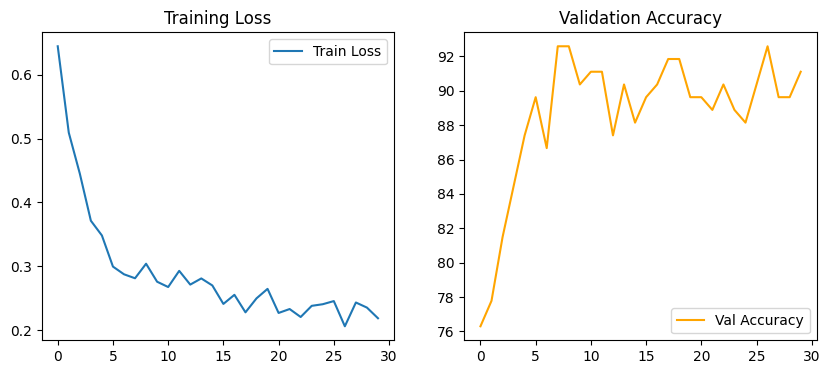

In [18]:
# PART 5: TRAINING CYCLE

import copy
import time

# Initialize the model
classifier = SceneChangeClassifier().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

EPOCHS = 30

print(f"Training starts ({EPOCHS} Epoch)...")
print("-" * 60)
print(f"{'Epoch':<8} | {'LR':<8} | {'Tr Loss':<8} | {'Val Acc':<8} | {'State':<10}")
print("-" * 60)

train_losses = []
val_accuracies = []

best_acc = 0.0
# Variable for storing the weights of the best model.
best_model_wts = copy.deepcopy(classifier.state_dict())

start_time = time.time()

for epoch in range(EPOCHS):
    #  TRAINING
    classifier.train()
    running_loss = 0.0

    for img1, img2, labels in train_loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
        labels = labels.unsqueeze(1)

        with torch.no_grad():
            emb1 = clip_model.encode_image(img1)
            emb2 = clip_model.encode_image(img2)

        optimizer.zero_grad()
        outputs = classifier(emb1, emb2)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    #  VALIDATION
    classifier.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for img1, img2, labels in val_loader:
            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)
            labels = labels.unsqueeze(1)

            emb1 = clip_model.encode_image(img1)
            emb2 = clip_model.encode_image(img2)
            outputs = classifier(emb1, emb2)
            preds = (outputs > 0.5).float()

            total += labels.size(0)
            correct += (preds == labels).sum().item()

    epoch_acc = 100 * correct / total
    val_accuracies.append(epoch_acc)

    # Save the best model (based on validation success)
    save_msg = ""
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(classifier.state_dict())
        save_msg = "*** Best ***"

    curr_lr = optimizer.param_groups[0]['lr']
    print(f"{epoch+1:<8} | {curr_lr:<8.5f} | {epoch_loss:<8.4f} | %{epoch_acc:<7.1f} | {save_msg}")

time_elapsed = time.time() - start_time
print("-" * 60)
print(f" TRAINING IS DONE ({time_elapsed//60:.0f}m {time_elapsed%60:.0f}s).")
print(f" HIGHEST VALIDATION SUCCESS: %{best_acc:.2f}")

# Optimize the model's weights.
classifier.load_state_dict(best_model_wts)
print(" The model was reverted to the settings that showed the best performance in the validation set.")

# Training Graph
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.title('Training Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(val_accuracies, color='orange', label='Val Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

 FINAL TEST & ERROR ANALYSIS STARTS...

 TEST SET ACCURACY: %87.41

              precision    recall  f1-score   support

  SAME SCENE       0.86      0.92      0.89        76
   DIFFERENT       0.89      0.81      0.85        59

    accuracy                           0.87       135
   macro avg       0.88      0.87      0.87       135
weighted avg       0.87      0.87      0.87       135



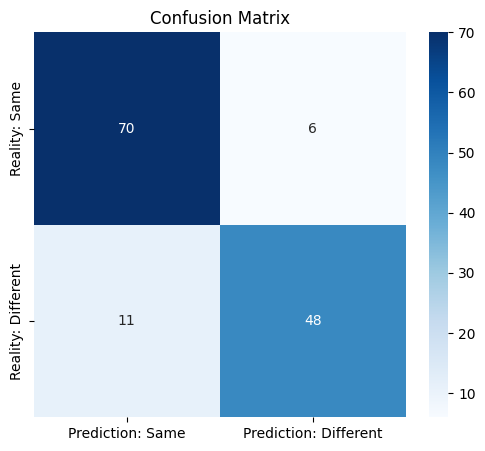

--------------------------------------------------
SCENARIO 1: Situations where the model cannot recognize the 'Same Scene' (possibly due to Augmentation)

 Reviewing: Reality: SAME | Prediction: DIFFERENT


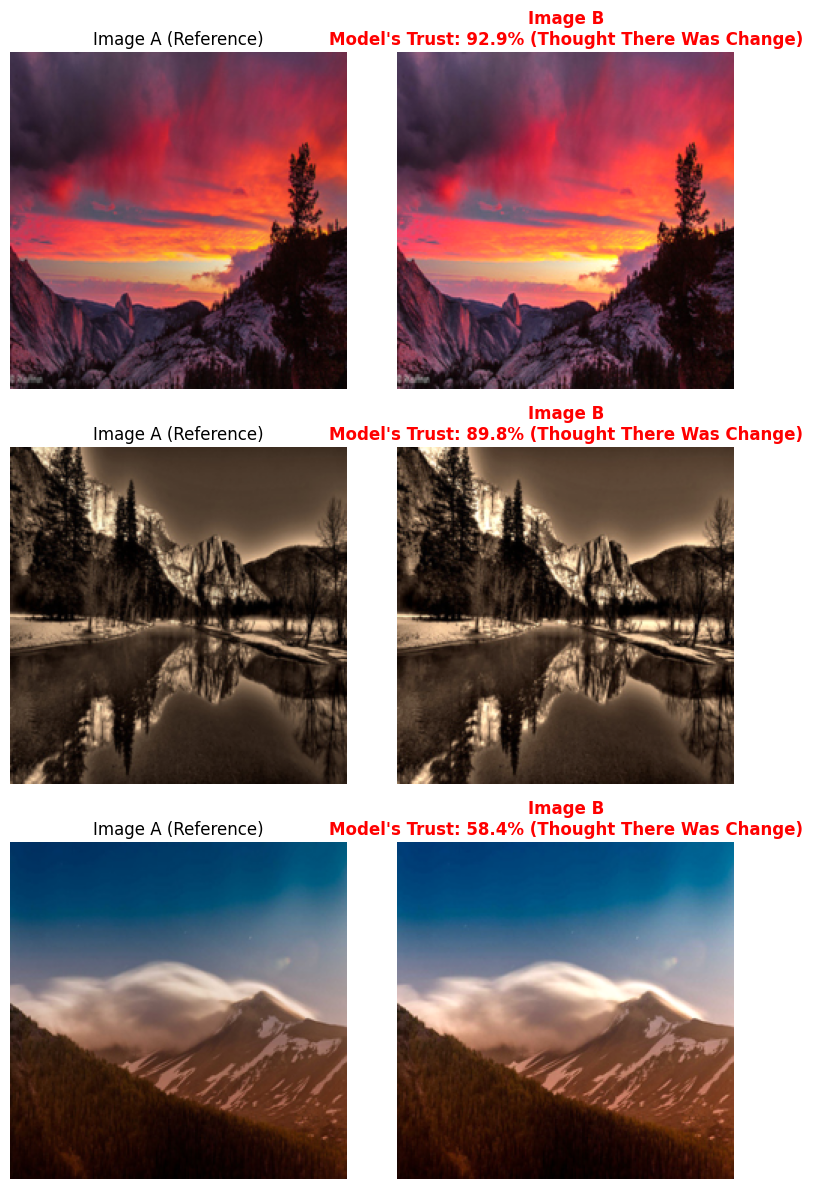

--------------------------------------------------
SCENARIO 2: Situations where the model 'missed the change'.

 Reviewing: Reality: DIFFERENT | Prediction: SAME


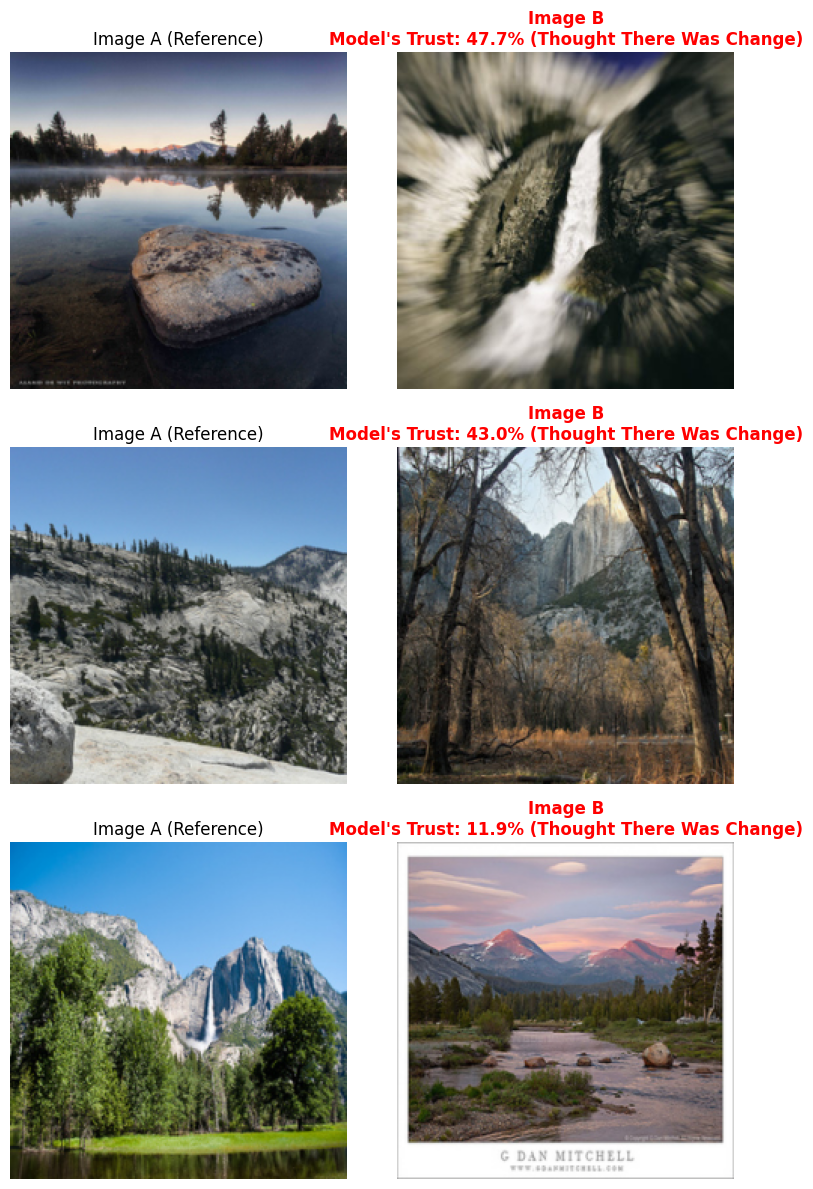

In [20]:
# PART 6: FINAL TEST & ERROR ANALYSIS (False Positives Vizualization)

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import torch

print(" FINAL TEST & ERROR ANALYSIS STARTS...")

# Put the model into evaluation mode.
classifier.eval()

test_preds = []
test_targets = []

# Lists to hide false examples
# False Positive: Actually the SAME (0), but the Model said DIFFERENT (1).
fp_examples = []

# False Negative: Actually DIFFERENT (1), but Model said SAME (0).
fn_examples = []

with torch.no_grad():
    for img1, img2, labels in test_loader:
        img1, img2, labels = img1.to(device), img2.to(device), labels.to(device)

        emb1 = clip_model.encode_image(img1)
        emb2 = clip_model.encode_image(img2)

        outputs = classifier(emb1, emb2)
        preds = (outputs > 0.5).float()

        # Save results
        test_preds.extend(preds.cpu().numpy())
        test_targets.extend(labels.cpu().numpy())

        #  CATCH THE ERRONEOUS EXAMPLES
        for i in range(len(labels)):
            true_label = labels[i].item()
            pred_label = preds[i].item()

            # Case 1: Actually the SAME (0), Model said DIFFERENT (1)
            if true_label == 0 and pred_label == 1:
                if len(fp_examples) < 5: # Store at most 5 samples
                    fp_examples.append((img1[i], img2[i], outputs[i].item()))

            # Case 2: Actually DIFFERENT (1), Model said SAME (0) (Missed change)
            if true_label == 1 and pred_label == 0:
                if len(fn_examples) < 5:
                    fn_examples.append((img1[i], img2[i], outputs[i].item()))

# 1. Numerical Report
final_acc = accuracy_score(test_targets, test_preds)
print(f"\n TEST SET ACCURACY: %{final_acc*100:.2f}\n")
print(classification_report(test_targets, test_preds, target_names=['SAME SCENE', 'DIFFERENT']))

# 2. Confusion Matrix
cm = confusion_matrix(test_targets, test_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Prediction: Same', 'Prediction: Different'],
            yticklabels=['Reality: Same', 'Reality: Different'])
plt.title('Confusion Matrix')
plt.show()

#  VISUALIZATION FUNCTION
def tensor_to_img(t):
    t = t.cpu()
    mean = torch.tensor([0.48145466, 0.4578275, 0.40821073]).view(3, 1, 1)
    std = torch.tensor([0.26862954, 0.26130258, 0.27577711]).view(3, 1, 1)
    img = t * std + mean
    return np.clip(img.permute(1, 2, 0).numpy(), 0, 1)

def plot_errors(error_list, title_prefix):
    if len(error_list) == 0:
        print(f"\n {title_prefix} No errors were found! The model is perfect in this respect.")
        return

    print(f"\n Reviewing: {title_prefix}")
    num_show = min(len(error_list), 3) # Show at most 3

    fig, axes = plt.subplots(num_show, 2, figsize=(8, 4*num_show))
    if num_show == 1: axes = [axes] # Avoid size errors if there is only one example.

    for i in range(num_show):
        img_a, img_b, conf = error_list[i]

        if num_show > 1: ax1, ax2 = axes[i]
        else: ax1, ax2 = axes[0], axes[1]

        ax1.imshow(tensor_to_img(img_a))
        ax1.set_title("Image A (Reference)")
        ax1.axis('off')

        ax2.imshow(tensor_to_img(img_b))
        ax2.set_title(f"Image B\nModel's Trust: {conf*100:.1f}% (Thought There Was Change)", color='red', fontweight='bold')
        ax2.axis('off')

    plt.tight_layout()
    plt.show()

# 3. Draw the errors
print("-" * 50)
print("SCENARIO 1: Situations where the model cannot recognize the 'Same Scene' (possibly due to Augmentation)")
plot_errors(fp_examples, "Reality: SAME | Prediction: DIFFERENT")

print("-" * 50)
print("SCENARIO 2: Situations where the model 'missed the change'.")
plot_errors(fn_examples, "Reality: DIFFERENT | Prediction: SAME")